# Quickstart: 入札オークションのシミュレーションと人工データセット (データ収集)
このノートブックは入札オークション (Real-Time Bidding; RTB) のシミュレーション環境から集められたログデータの可視化の例を紹介します．

特に、以下の3つの順番で解説していきます: 

0. (シミュレーション環境の設定とオンライン強化学習)
1. 離散行動空間における事例
2. 連続行動空間における事例
3. 複数のデータ収集方策方策やランダムシードによるログデータの収集


このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [1]:
# SCOPE-RL モジュールのインポート
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch
from sklearn.utils import check_random_state

In [2]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [4]:
# random stateの設定
random_state = 12345
random_ = check_random_state(random_state)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 0. (シミュレーション環境の設定とオンライン強化学習)
まず初めに，今回用いるRTB環境を紹介します．

#### 強化学習でのRTB環境のセットアップ
RTBにおいて強化学習エージェントの目的は，予算制約が与えられもとで，一つのエピソード内でのKPI(クリックやコンバージョン)を最大化することです. KPIを最大にするために，エージェントは入札価格関数パラメータ $\alpha$ を選択します．
入札価格関数パラメータ $\alpha$ を利用することで以下の入札価格を決定します．\
$bid_{t，i} = \alpha \cdot r^{\ast}$，
ここで$r^{\ast}$はKPIの予測値または期待値を表します.

この問題を制約付きマルコフ決定過程(CMDP)として定式化します.

- `タイムステップ`: 一つのエピソード(一日，一週間)に含まれるタイムステップ(24時間，数日など).
- `状態`: それぞれのタイムステップで，環境からフィードバックが返ってきます.
  - タイムステップ
  - 残予算
  - 一つ前のタイムステップでのインプレッション単位の特徴(予算消費率，一つのインプレッションあたりのコスト，オークション落札率，報酬)
  - 一つ前のタイムステップでの入札関数パラメータ(強化学習エージェントが選ぶ行動) 
- `行動`: エージェントはKPIを最大化するために入札価格パラメータ$\alpha$を選択します.
- `報酬`: 一つのタイムステップあたりに得られたクリックまたはコンバージョンの合計数.
- `制約`: あらかじめ決められた、一つのエピソードあたりの予算．


In [7]:
# 環境のセットアップ
env = RTBEnv(random_state=random_state)

In [8]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # 方策が取りうる最小の値
            maximum=10,  # 方策が取りうる最大の値
        )
    ).create(device=device),
    name="random",
)

In [9]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [10]:
# 環境からのフィードバック
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


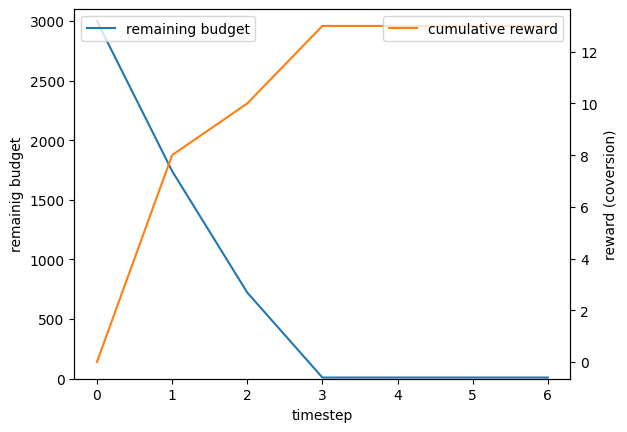

In [11]:
# 累積報酬と残予算の変遷を可視化しています
# 目的は予算制約の中で強化学習を利用して, 累積報酬を最大化する方策を得ることです
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# プロット
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

より詳細に環境の引数を確認したい場合は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).

## 1. 離散行動空間
まずは行動空間が離散の場合にデータ収集方策からどのようにデータを収集するかを紹介します．

ここでは2つの手順を必要とします．
1. ベースとなる決定的 (非確率的) な方策を学習する．
2. 決定的な方策を用い確率的な方策を定義する．

決定的な方策を学習する際は[d3rlpy](https://github.com/takuseno/d3rlpy)を利用します．

In [12]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("RTBEnv-discrete-v0")

In [14]:
# データ生成のためのベースとなる決定的方策の学習
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)
# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [16]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [17]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 16:49:50 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy 方策

ここでは学習した決定的な方策から確率的方策を定義します．

今回用いるepsilon-greedy方策では，$1 - \epsilon$の確率で貪欲に行動を選択し，$\epsilon$の確率でランダムな行動を選択します．

$$\pi(a | s) := (1 - \epsilon) * \pi_{\mathrm{det}}(a | s) + \epsilon / |\mathcal{A}|,$$

ここで$a \in \mathcal{A}$ は行動，$s \in \mathcal{S}$は状態，$\pi$ は決定的なベース方策$\pi_{\mathrm{det}}$を用いて定義された確率的方策です．

このepsilon-greedy方策をデータ収集方策として人工データを生成しますが、その際に用いる`SyntheticDataset` は以下の引数を持っています:
- `env`: 前のセクションで紹介したRTB環境を定義.
- `state_keys`: 状態変数の名前.
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）.


より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).

In [18]:
# ddqn方策を確率的なデータ収集方策に変えます
from scope_rl.policy import EpsilonGreedyHead

behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # ランダムな行動をとる確率
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [ ]:
# データ生成
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [20]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.15434279e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         9.90049751e-01, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 9.79000000e+02, 5.27965284e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

In [21]:
# データの統計量
# 報酬は離散的な場合と同様にスパースになっています
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.0000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.292270,131.269011,75.2031,7.914886,2.025843,0.412287,0.055333,0.116279
std,3.103391,158.513015,89.8231,9.930448,3.082174,0.439671,0.077373,0.170241
min,0.000012,4.004975,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,4.705882,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.774264,59.980375,6.0000,0.000000,0.000000,0.201856,0.000000,0.000000
75%,2.159631,278.317592,179.0000,17.000000,4.000000,0.995327,0.104478,0.217391
max,10.000000,546.900000,290.0000,48.000000,20.000000,1.000000,0.999995,0.999998


In [22]:
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.292270,131.269011,75.203100,7.914886,2.025843,508.401300
std,0.945540,52.736378,14.261024,1.462237,0.629777,636.963511
min,0.135120,7.631997,0.285714,0.000000,0.000000,1.000000
25%,1.811682,96.116198,69.000000,7.857143,1.571429,21.000000
50%,2.180416,129.916298,76.857143,8.428571,2.000000,54.000000
75%,2.864227,168.969656,83.714286,8.714286,2.428571,1039.000000
max,6.086100,345.044714,119.714286,10.142857,4.857143,3000.000000


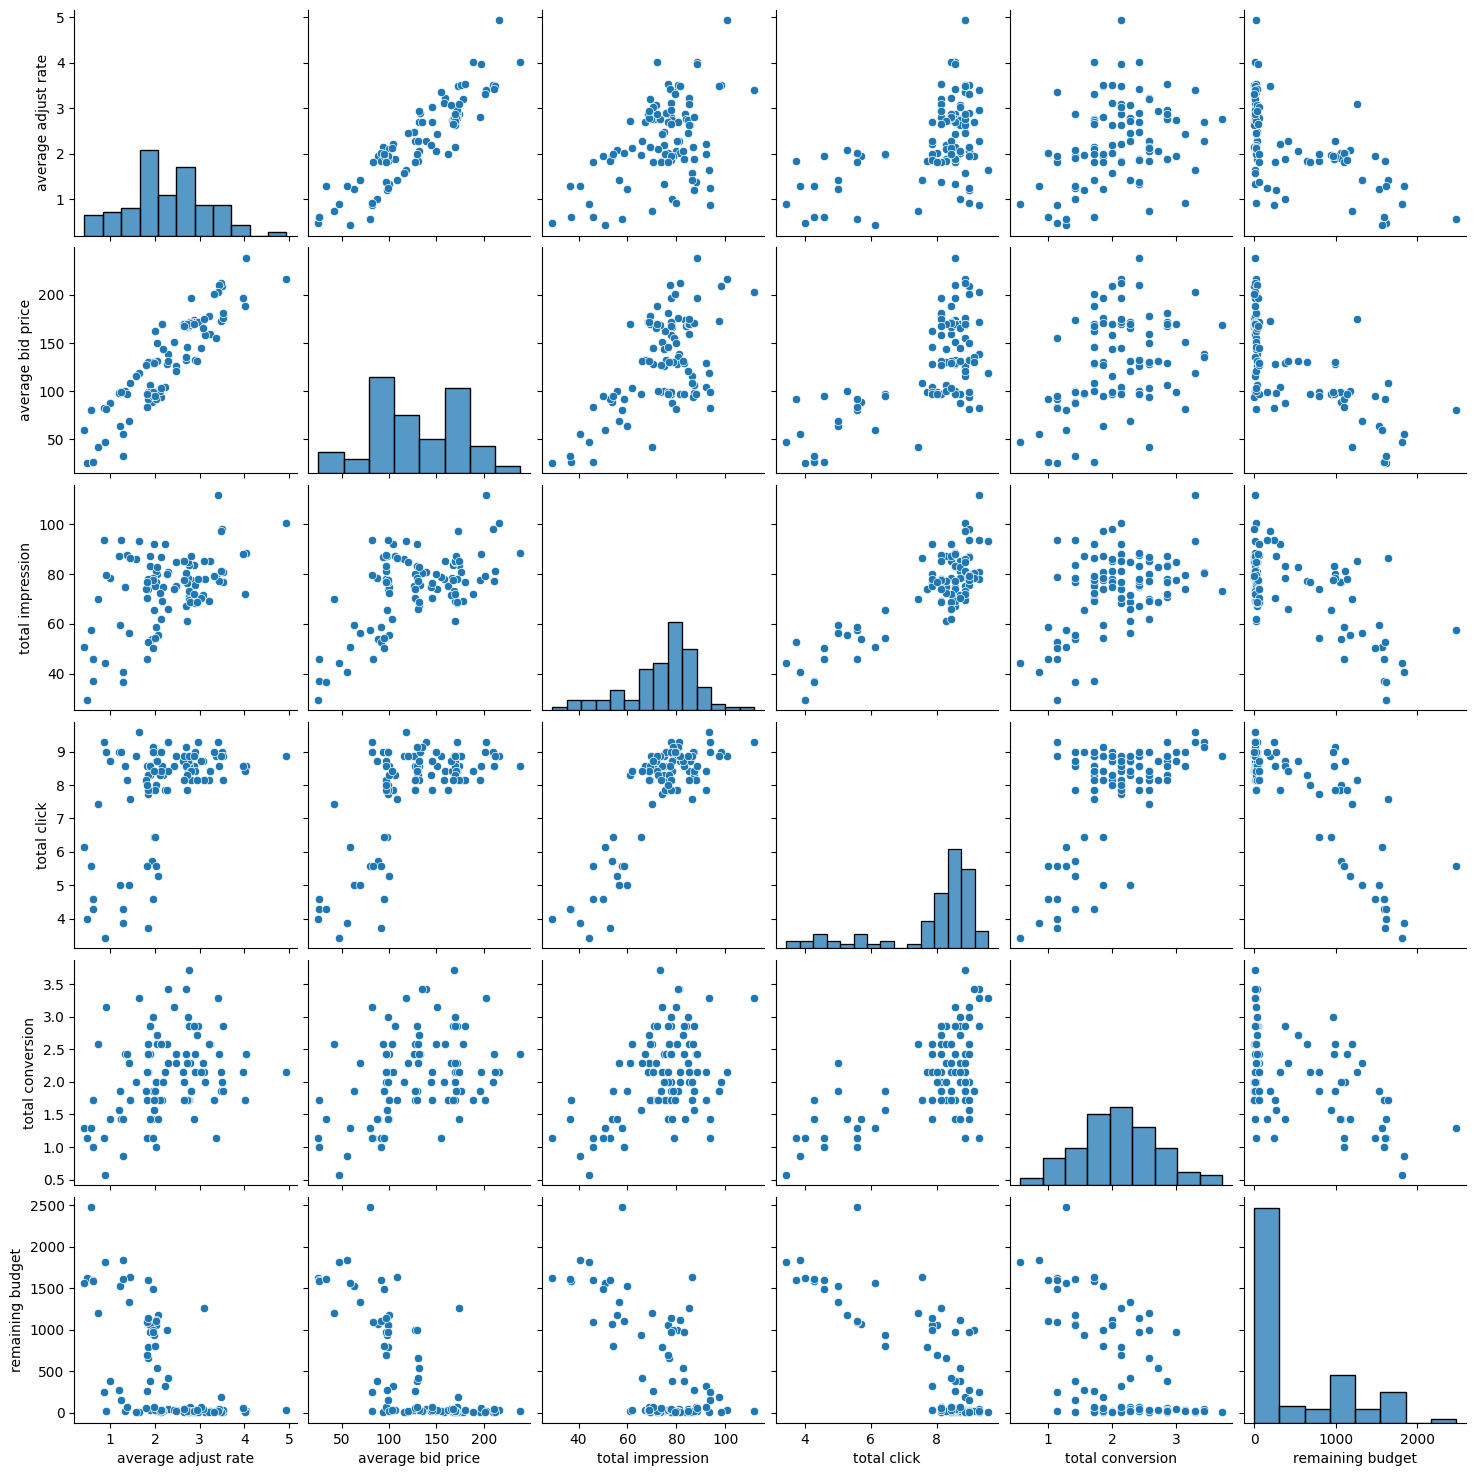

In [23]:
# we see a strong correlation between number of impression and click.クリックとインプレッションには強い正の相関があります
# コンバージョンにつながらないクリックが多く発生しています
sns.pairplot(df_[:100])

### 1.2. ソフトマックス方策
次に，epsilon-greedyの代わりに`SoftmaxHead`を用いて確率的なデータ収集方策を定義します．

ソフトマックス方策は，状態と行動のペア$(s, a)$が与えられた時に価値を推定するQ関数$Q(s, a)$を用い、以下のように確率的に行動を選択します．

$$\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)},$$

$\tau$ は方策のエントロピーを調整する温度パラメータです．

In [24]:
# ddqn方策を確率的なデータ収集方策に変えます
from scope_rl.policy import SoftmaxHead

behavior_policy = SoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [ ]:
# データ生成
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [26]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 6.43101135e-01],
        [1.00000000e+00, 3.00000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.78255940e-01],
        [2.00000000e+00, 3.00000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.78255940e-01],
        ...,
        [4.00000000e+00, 1.90500000e+03, 3.65000000e-01, ...,
         1.00000000e+00, 4.00000000e+00, 1.00000000e+0

In [27]:
# データの統計量
# 報酬がスパースになっている
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.773876,98.360753,68.533957,7.137486,1.666314,0.380639,0.056165,0.104472
std,2.532414,135.622399,87.575986,9.531898,2.729116,0.428933,0.085250,0.166036
min,0.000165,4.011429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166810,7.891987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.464159,23.953916,4.000000,0.000000,0.000000,0.140983,0.000000,0.000000
75%,2.154435,115.488738,172.000000,16.000000,3.000000,0.944746,0.102804,0.187500
max,10.000000,547.265957,276.000000,47.000000,20.000000,1.000000,0.999997,0.999998


In [28]:
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.773876,98.360753,68.533957,7.137486,1.666314,807.798500
std,0.976728,52.883208,21.721911,2.210259,0.732255,860.252136
min,0.162882,6.636410,0.000000,0.000000,0.000000,1.000000
25%,0.960473,55.960386,57.000000,5.857143,1.142857,29.000000
50%,1.651326,93.292262,74.142857,8.142857,1.714286,548.000000
75%,2.383959,132.519422,84.000000,8.714286,2.142857,1443.000000
max,6.230459,336.219291,121.571429,10.571429,4.285714,3000.000000


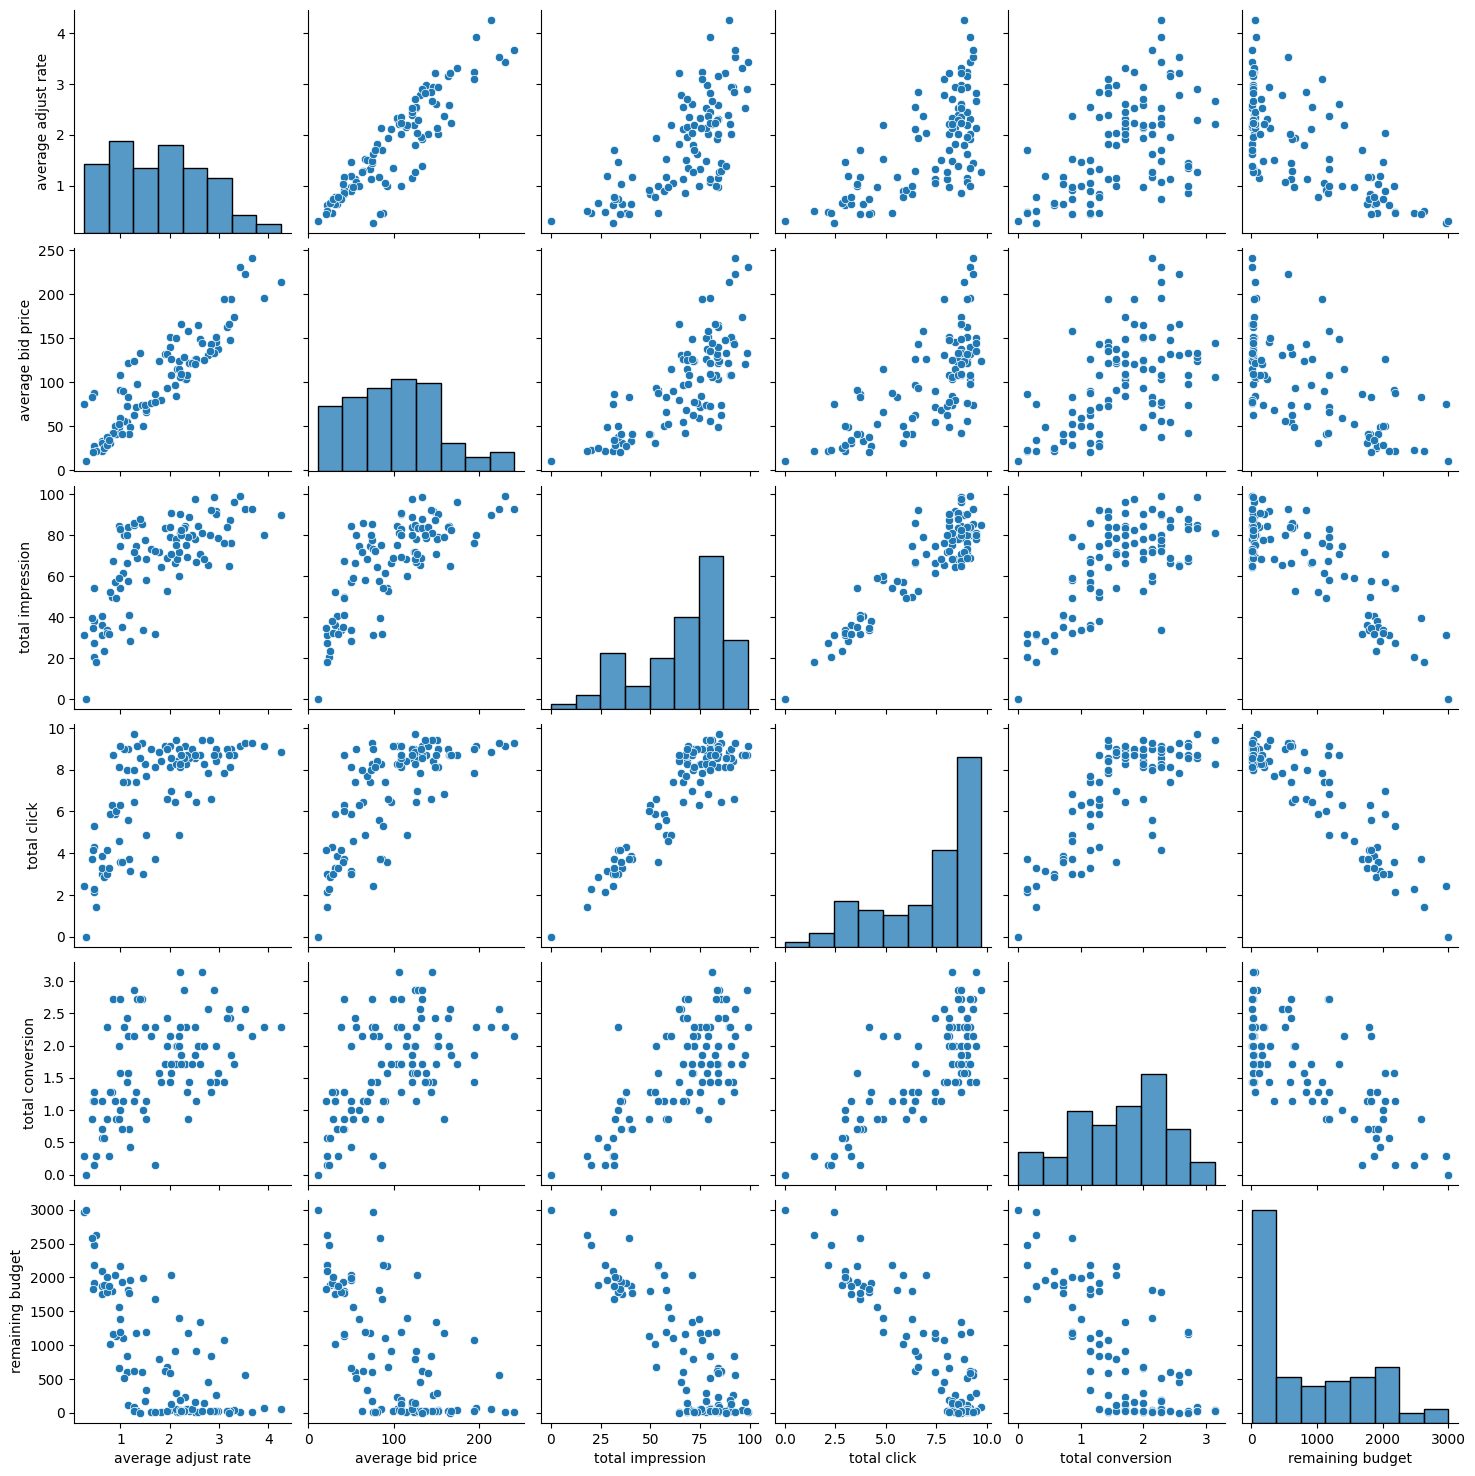

In [29]:
# ソフトマックス方策はepsilon-greedy方策方策よりインプレッションを多く得られるものの，コンバージョンが少なくなっています
sns.pairplot(df_[:100])

離散行動空間でのオフライン強化学習やオフ方策評価 (OPE) に関しては，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb).

オフ方策評価 (OPE) や オフ方策選択 (OPS) に関する発展的なトピックは以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb).

## 2. 連続行動空間
まずは離散行動の場合と同様に，ベースとなる決定的な方策を学習します．

In [31]:
# SCOPE-RLで実装されている連続行動空間に対する標準的な環境
env = gym.make("RTBEnv-continuous-v0")

In [32]:
# データ生成のベースとなる決定的方策の学習
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# モデル
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [35]:
# モデルの保存
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# モデルのリロード
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2023-07-22 17:04:29 [warning  ] Parameters will be reinitialized.


### 2.1. ガウス方策

ここでは，学習した決定的方策にノイズを加えることで確率的方策を定義します． 

今回は，`BasicEnv`の有界な行動空間に対応するために，`TruncatedGaussianHead`を利用します．
この方策は決定的方策$\pi(s)$の選ぶ行動に応じて, 切断ガウス分布から行動をサンプリングします．
$$a \sim Truncnorm(\pi(s), \sigma),$$

ここで$\sigma$ノイズの大きさを表しています．

行動空間が有界でない時は, `GaussianHead`を利用できます．

In [35]:
# ddqn方策を確率的なデータ収集方策に変えます
from scope_rl.policy import TruncatedGaussianHead

behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # 行動空間の下限
    maximum=env.action_space.high,  # 行動空間の上限
    sigma=np.array([1.0]),  # ガウシアン分布のノイズスケール
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [ ]:
# データ収集
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [37]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 7.38851424e-01],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 5.41722533e+00],
        [2.00000000e+00, 1.17300000e+03, 3.85863874e-01, ...,
         1.00000000e+00, 1.00000000e+00, 9.04188838e+00],
        ...,
        [4.00000000e+00, 2.20000000e+01, 0.00000000e+00, ...,
         3.38164251e-02, 0.00000000e+00, 9.91771869e+00],
        [5.00000000e+00, 2.20000000e+01, 0.00000000e+00, ...,
         4.92610837e-03, 0.00000000e+00, 7.81845410e+00],
        [6.00000

In [38]:
# データの統計量
# 報酬は離散的な場合と同様にスパースになっています

df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,6.592979,382.843519,91.830129,8.580243,2.053800,0.526100,0.055684,0.125776
std,3.113360,100.143291,90.748515,9.548014,3.030225,0.432456,0.062548,0.180461
min,0.000027,4.901478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.488277,342.836634,6.000000,0.000000,0.000000,0.050251,0.000000,0.000000
50%,8.009422,412.295648,34.000000,2.000000,0.000000,0.547117,0.062500,0.000000
75%,9.108331,448.845318,190.000000,18.000000,3.000000,1.000000,0.099502,0.214286
max,10.300053,548.952381,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


In [39]:
# 離散的な場合と比較すると，残りの予算は少なくなっており，連続的な場合の方が柔軟性があることがわかります
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,6.592979,382.843519,91.830129,8.580243,2.053800,17.44850
std,0.602869,30.625998,10.732850,0.357118,0.482136,12.07078
min,3.745769,248.655743,53.142857,7.285714,0.428571,1.00000
25%,6.203521,363.019623,84.571429,8.285714,1.714286,7.00000
50%,6.643230,385.472716,91.142857,8.571429,2.000000,16.00000
75%,7.038746,405.814897,98.571429,8.857143,2.428571,25.00000
max,8.311466,456.525261,133.000000,10.000000,4.142857,85.00000


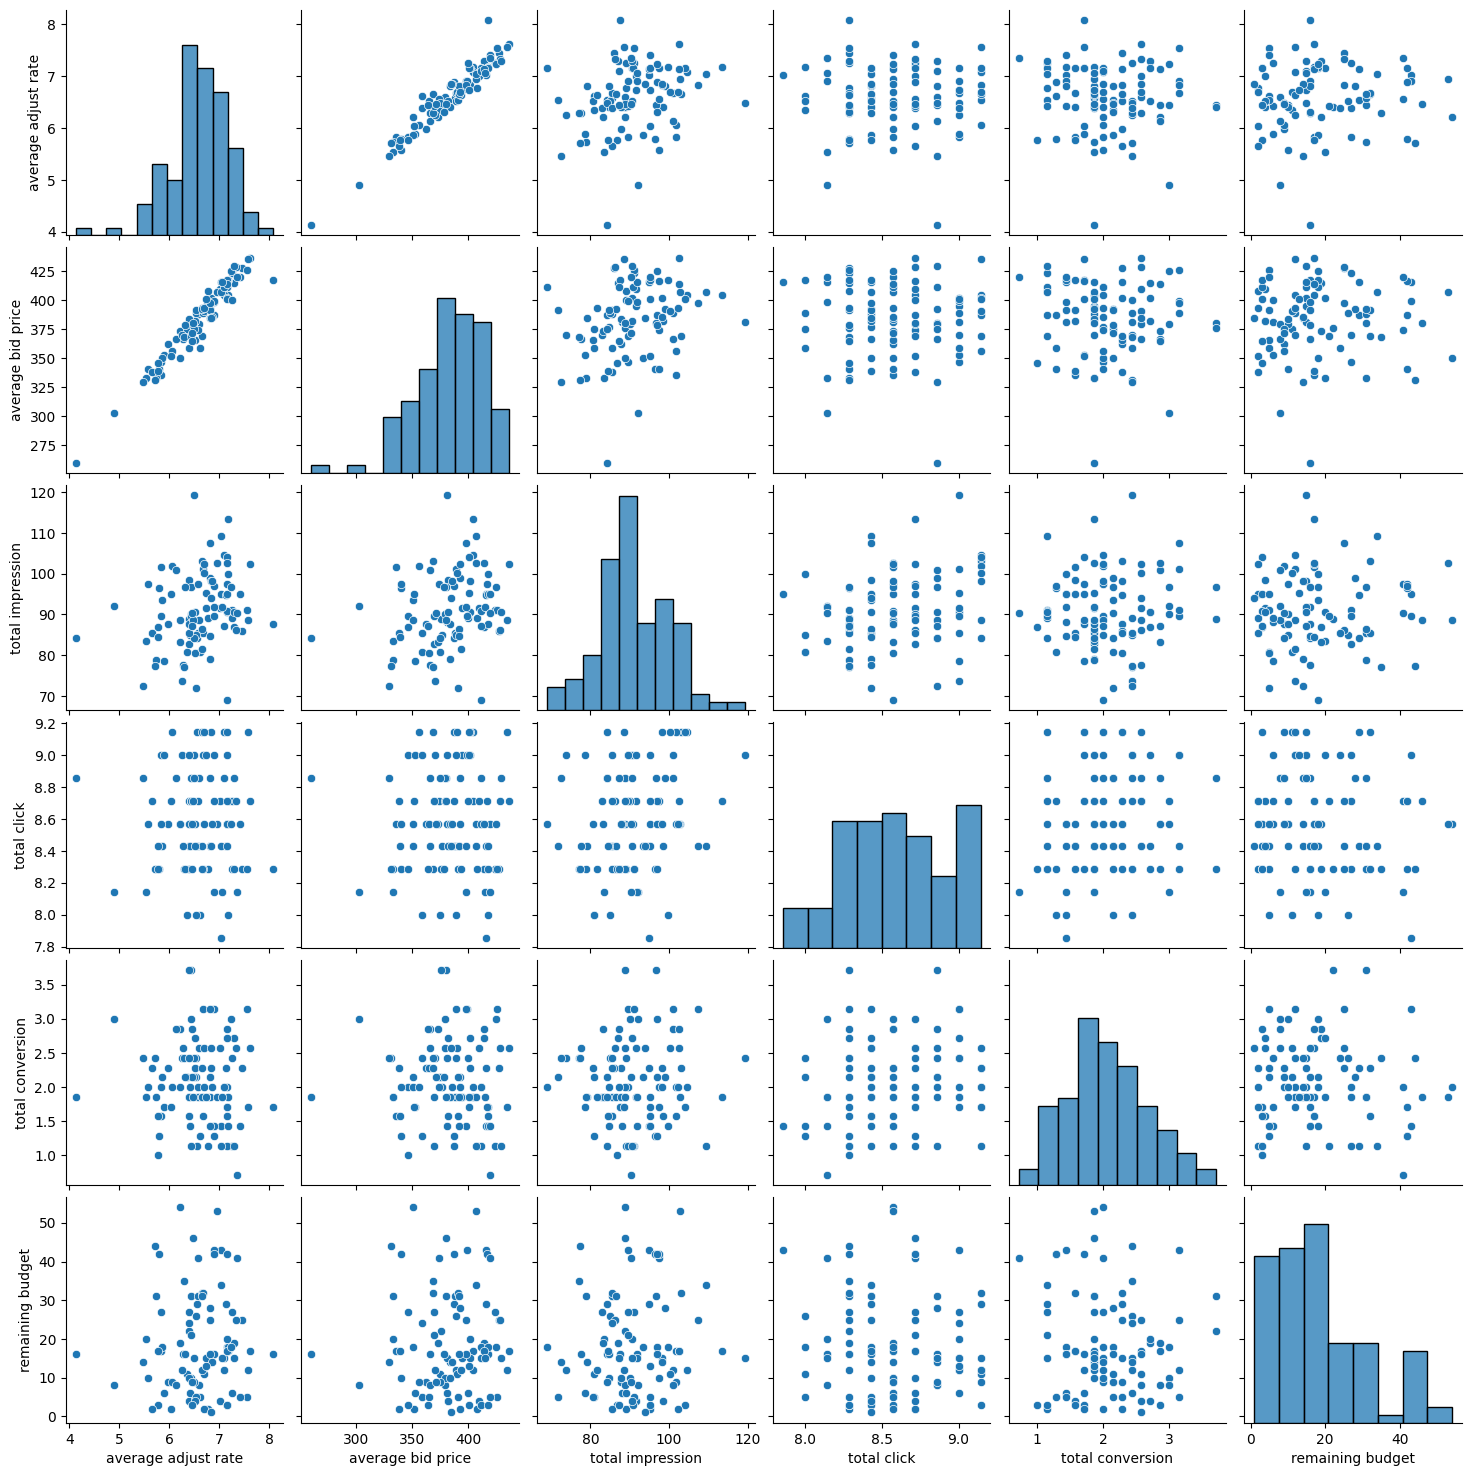

In [40]:
# 入札価格とインプレッションには僅かに負の相関があります
sns.pairplot(df_[:100])

オフライン強化学習やオフ方策評価 (OPE) に関しては以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb). 

OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください.[examples/quickstart_ja/rtb/rtb_synthetic_continuous_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_advanced_ja.ipynb).

## 3. 複数のデータ収集方策方策やランダムシードによるログデータの収集
最後に，複数のデータ収集方策とランダムシードを用いてログデータを収集する際の効率的な実装方法を紹介します．

離散行動の場合を紹介しますが，連続行動の場合も同様に扱うことができます．

In [41]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("RTBEnv-discrete-v0")

In [42]:
# データ収集方策を定義
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,  # ランダムな行動をとる確率
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # ランダムな行動をとる確率
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,  # ランダムな行動をとる確率
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,  # ランダムな行動をとる確率
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [43]:
# データクラスの初期化
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [ ]:
logged_datasets = dataset.obtain_episodes(
    behavior_policies=behavior_policies,
    n_datasets=2,  #ランダムシードの数
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [45]:
logged_dataset = logged_datasets.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.87517002e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e-01],
        ...,
        [4.00000000e+00, 9.79000000e+02, 5.27965284e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

複数のデータを用いたオフライン強化学習やオフ方策評価 (OPE) に関しては，以下を参照してください [examples/quickstart_ja/rtb/rtb_synthetic_discrete_multiple_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_multiple_ja.ipynb) (離散行動空間) ，[examples/quickstart_ja/rtb/rtb_synthetic_continuous_multiple_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_multiple_ja.ipynb) (連続行動空間). 

## 参考文献

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.